[View in Colaboratory](https://colab.research.google.com/github/MChamith/SpatioAE/blob/master/trainae.ipynb)

In [1]:
!git clone https://github.com/MChamith/SpatioAE

Cloning into 'SpatioAE'...
remote: Counting objects: 7174, done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 7174 (delta 16), reused 6 (delta 2), pack-reused 7142
Receiving objects: 100% (7174/7174), 275.57 MiB | 29.46 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Checking out files: 100% (7205/7205), done.


In [0]:
import os
os.chdir('SpatioAE')
!pwd
!git pull https://github.com/MChamith/SpatioAE
os.chdir('/content')  
!pwd

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [2]:

from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
from keras.optimizers import Adam
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model
from keras import regularizers

Using TensorFlow backend.


In [0]:

from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model

TRAIN_DIR ='SpatioAE/Train'
TEST_DIR = 'drive/Data/datasets/Test032'
IMG_SIZE = 128



def create_training_set():
  train_data = []
  matches = []
  for root, dirnames, filenames in tqdm(os.walk(TRAIN_DIR)):
    for filename in fnmatch.filter(filenames, "*.tif"):
      path = os.path.join(root, filename)
      img = image.load_img(path, target_size=(128,128), grayscale = True)
      img_array = image.img_to_array(img)
#       print("img array size is " + str(img_array.shape))
#       img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#       img_array = np.expand_dims(img_array, axis = 2)
      train_data.append(np.array(img_array))
          
  np.save('training_data.npy' , train_data)
  
  return train_data

      
    
    
#   for img in tqdm(os.listdir(TRAIN_DIR)):
#     path = os.path.join(TRAIN_DIR, img)
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
#     train_data.append(np.array(img))
    
    
#   np.save('training_data.npy' , train_data)
  
#   return train_data


def create_test_set():
  test_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, img)
    img = image.load_img(path, target_size=(128,128), grayscale = True)
    img_array =image.img_to_array(img)
    
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
    test_data.append(np.array(img_array))
    
    
  np.save('test_data32.npy' , test_data)
  return test_data

In [0]:
def create_cuboid(input_imgs):
  
  win_size = 16
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  a = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    a.append(window)
#     print('i = ' + str(i))
   
#   cuboid = np.hstack(a)
  np.save('hyper_cuboid_win16.npy' , a)
  return a

  
  

In [0]:
def create_test_cuboid(input_imgs):
  
  win_size = 8
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  t = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    t.append(window)
   
#   cuboid = np.hstack(a)
  np.save('test_hyper_cuboid_win8_32.npy' , t)
  return t

In [15]:
# create_training_set()
print('started')
input_data = np.load('training_data.npy')
print('training data loaded')
input_data = input_data.astype('float32') / 255
print('data normalized')
create_cuboid(input_data)
print('cuboid created')
img_cuboids = np.load('hyper_cuboid_win16.npy')
print(img_cuboids.shape)


started
training data loaded
data normalized
cuboid created
(6785, 16, 128, 128, 1)


In [0]:
input_data = np.load('drive/Data/training_data.npy')

In [0]:

input_data = input_data.astype('float32') / 255.
create_cuboid(input_data)

In [0]:
print(img_cuboids.shape)

(6785, 16, 128, 128, 1)


In [0]:
print(img_cuboids.shape)

(6785, 16, 128, 128, 1)


In [0]:

def model_autoencoder():
  
  input_img  = Input(shape = (16,128,128,1))  #channel last
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(input_img)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer one conv " + str(x.shape))
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' ,kernel_regularizer=regularizers.l2(0.01), kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer two conv " + str(x.shape))
  
 
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2), padding= 'same')(x)
  print("layer three conv " + str(x.shape))
  
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  encoded = MaxPooling3D(pool_size = (1,1,1), strides = (1,1,1))(x)
  print("layer four conv " + str(encoded.shape))
  
  
  ## decoder branch
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(encoded)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer one deconv " + str(x.shape))
 
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer two deconv " + str(x.shape))
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer three deconv " + str(x.shape))
  decoded = Conv3D(filters = 1, kernel_size = (3,3,3), strides = (1,1,1), padding = 'same', activation = 'sigmoid',kernel_regularizer=regularizers.l2(0.01))(x)
  print("output" + str(decoded.shape))

  
  
  autoencoder = Model(input_img, decoded)
  
  return autoencoder
  

In [0]:
os.chdir('SpatioAE')
!pwd
!git config --global user.email "charmiemawela02@gmail.com"
!git config --global user.name "MChamith"
!git add hyper_cuboid.npy
!git commit -m "hyper cuboid"
!git push origin master
!pwd
os.chdir('/content')  
!pwd


In [0]:
# create_training_set()
# input_imgs = np.load('training_data.npy')
# create_cuboid(input_imgs)
img_cuboids = np.load('hyper_cuboid_win16.npy')
print("hyper cuboid loaded")
img_cuboids = img_cuboids.astype('float32') / 255.
print("data normalized")
# K.clear_session()
# autoencoder = model_autoencoder()
# autoencoder.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['acc'])
# print("model compiled")
# autoencoder.fit(img_cuboids,img_cuboids,  epochs =10, batch_size= 32)
# print("model fitted")
  
    

hyper cuboid loaded


In [17]:
K.clear_session()
autoencoder = model_autoencoder()
autoencoder.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['acc','mae'])
print("model compiled")
autoencoder.fit(img_cuboids,img_cuboids,  epochs =10, batch_size= 4)
print("model fitted")

layer one conv (?, 8, 64, 64, 32)
layer two conv (?, 4, 32, 32, 48)
layer three conv (?, 2, 16, 16, 64)
layer four conv (?, 2, 16, 16, 64)
layer one deconv (?, 4, 32, 32, 48)
layer two deconv (?, 8, 64, 64, 32)
layer three deconv (?, 16, 128, 128, 32)
output(?, 16, 128, 128, 1)
model compiled
Epoch 1/10
6785/6785 [==============================] - 985s 145ms/step - loss: 0.0461 - acc: 1.3219e-05 - mean_absolute_error: 0.0595
Epoch 2/10
6785/6785 [==============================] - 981s 145ms/step - loss: 0.0167 - acc: 1.3429e-05 - mean_absolute_error: 0.0546
Epoch 3/10
6785/6785 [==============================] - 980s 144ms/step - loss: 0.0121 - acc: 1.3666e-05 - mean_absolute_error: 0.0493
Epoch 4/10
6785/6785 [==============================] - 981s 145ms/step - loss: 0.0129 - acc: 1.3559e-05 - mean_absolute_error: 0.0482
Epoch 5/10
6785/6785 [==============================] - 981s 145ms/step - loss: 0.0117 - acc: 1.3931e-05 - mean_absolute_error: 0.0467
Epoch 6/10
6785/6785 [=========

In [0]:
autoencoder.save('drive/Data/3d_autoencoder_model_iter1_win16.h5')



In [0]:
autoencoder.save('3d_autoencoder_model_iter1_win16.h5')

In [0]:
from keras.models import load_model 
K.clear_session()
autoencoder_model = load_model('drive/Data/3d_autoencoder_model_iter1_win16.h5')
# autoencoder_model.summary()

In [0]:
autoencoder_model.save('drive/Data/3d_autoencoder_model_iter1_win16.h5')

In [0]:
autoencoder_model.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['acc','mae'])
# print("model compiled")
# # autoencoder.fit(img_cuboids,img_cuboids,  epochs =10, batch_size= 32)
# print("model fitted")

In [62]:
print(K.eval(autoencoder_model.optimizer.lr))
K.clear_session()

0.001


In [0]:
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3 ,min_lr=0.00001)

img_cuboids = np.load('hyper_cuboid_win16.npy')       
model_history = autoencoder_model.fit(img_cuboids,img_cuboids,  epochs =10, batch_size=4, callbacks=[history,reduce_lr],validation_split = 0.1)  
autoencoder_model.save('3d_autoencoder_model_iter2_win16.h5')
autoencoder_model.save('drive/Data/3d_autoencoder_model_win16_iter2.h5')

In [0]:
autoencoder_model.save('3d_autoencoder_model_iter2.h5')


NameError: ignored

In [0]:
train_loss = np.array(history.losses)
# train_loss = train_loss[16965-6785:16965]
# train_loss_normed = np.linalg.norm(train_loss)
min_ex = min(train_loss)
max_ex = max(train_loss)

print('minimum loss = ' + str(min_ex) + 'maximum loss= ' + str(max_ex)+ 'train losss = '+str(train_loss.shape))

minimum loss = 0.0006428565maximum loss= 0.0050993245train losss = (1697,)


In [55]:
# get_test_data = create_test_set()
# test_imgs = np.load('test_data32.npy')
# test_imgs = test_imgs.astype('float32') / 255.
# create_test_cuboid(test_imgs)
test_cuboid = np.load('test_hyper_cuboid_win16_32.npy')

print(test_cuboid.shape)




(185, 16, 128, 128, 1)


In [0]:
for i in range(2):
  for j in range(8):
    scipy.misc.imsave('drive/Data/testimage'+str(n)+'.png', np.squeeze(test_cuboid[i][j], axis = 2))
#   sq_img = np.squeeze(test_cuboid[n][1], axis = 2)
#   sq_img = sq_img*255
#   sq_img = sq_img.astype('uint8')

#   dec_img = np.squeeze(decode_imgs[n][1], axis = 2)
#   dec_img = dec_img*255
#   dec_img = dec_img.astype('uint8')

  
#   scipy.misc.imsave('drive/Data/dec'+str(n)+'.png', dec_img)
  

In [0]:
decode_imgs = autoencoder_model.predict(test_cuboid)

In [0]:
print(np.squeeze(decode_imgs[1][1]))
print(np.squeeze(test_cuboid[1][1]))

[[0.3665918  0.31407773 0.4027053  ... 0.33415452 0.15355128 0.2725734 ]
 [0.28767076 0.25165272 0.4176241  ... 0.33526462 0.19010405 0.32217863]
 [0.3285036  0.36008832 0.26042366 ... 0.3353285  0.29230455 0.4493007 ]
 ...
 [0.41672572 0.41849038 0.41418377 ... 0.6470401  0.66060466 0.75101554]
 [0.43709612 0.44734138 0.4424473  ... 0.6860009  0.67404884 0.7712986 ]
 [0.439424   0.4661526  0.475611   ... 0.72254467 0.70244664 0.7338248 ]]
[[0.34901962 0.30588236 0.3882353  ... 0.31764707 0.16078432 0.26666668]
 [0.2509804  0.26666668 0.41568628 ... 0.32156864 0.1764706  0.31764707]
 [0.30980393 0.36862746 0.2627451  ... 0.34117648 0.2784314  0.49803922]
 ...
 [0.40784314 0.4        0.40784314 ... 0.654902   0.6627451  0.7137255 ]
 [0.44705883 0.4627451  0.45490196 ... 0.67058825 0.64705884 0.72156864]
 [0.4627451  0.4627451  0.4745098  ... 0.69411767 0.6666667  0.7372549 ]]


In [0]:
real_img = np.load('test_data.npy')
	diff=x1-x2
	a,b,c,d,e=diff.shape
	n_samples=a*b*c*d*e
	sq_diff=diff**2
	Sum=sq_diff.sum()
	dist=np.sqrt(Sum)
	mean_dist=dist/n_samples

	return mean_dist

In [0]:
def calculate_score(input_img, reconstructed_img):
  diff = input_img - reconstructed_img
  a,b,c=diff.shape
  n_samples=a*b*c
  sq_diff=diff**2
  Sum=sq_diff.sum()
  dist=np.sqrt(Sum)
  mean_dist=dist/n_samples
  return mean_dist
  

In [0]:
def calculate_costs(img_size, win_size):
  
  input_size = img_size+win_size
  costs = np.zeros(img_size+win_size-1, dtype= float)
#   if img_size+win_size > num_input:
#     break
    
  for i in range(0, img_size):
    for k in range(win_size):
      temp = np.squeeze(test_cuboid[i])-np.squeeze(decode_imgs[i][k])
      costs[i+k]= np.linalg.norm(temp)
			
  
  np.save('test_costs_win16_iter1.1_test32.npy',costs)
  return costs
    
  
  
  
  

In [0]:
def calculate_costs_tset(img_size, win_size):
  
  input_size = img_size+win_size
  costs = np.zeros(img_size+win_size-1, dtype= float)
#   if img_size+win_size > num_input:
#     break
    
  for i in range(0, img_size):
    for k in range(win_size):
#       temp = np.squeeze(test_cuboid[i][k])-np.squeeze(decode_imgs[i][k])
      temp = calculate_score(test_cuboid[i][k],decode_imgs[i][k])
      costs[i+k]= np.linalg.norm(temp)
			
  
  np.save('test_costs_test.npy',costs)
  return costs
    

In [0]:
print(np.linalg.norm(np.squeeze(decode_imgs[1][2])-np.squeeze(test_cuboid[1][2])))

7.740723


In [58]:
calculate_costs(test_cuboid.shape[0],16)
cost_val = np.load('test_costs_win16_iter1.1_test32.npy')
print(cost_val)


[52.63457108 52.64853287 52.48007584 51.89611053 51.80197144 51.42992401
 51.36011887 51.38239288 51.65817642 51.64880371 51.86912537 51.63276291
 51.70547104 51.75514603 51.95462799 51.87023163 52.19790268 52.3370018
 52.46575165 52.51546478 52.61783218 52.60110092 52.77394867 52.7602272
 52.90536499 52.65096283 52.17260361 51.72653198 51.14848328 50.73793793
 49.63319397 48.94400024 49.00098038 49.05098343 49.19877625 49.12088394
 49.00687408 49.15299988 49.31871414 49.45385742 49.6756134  49.80994034
 50.10173798 50.20698929 50.60487747 50.54717255 50.83545303 50.84452438
 51.15742874 50.9068222  50.89818573 50.48047256 50.45874786 50.80020905
 50.88718414 51.04969788 51.04623795 51.29576111 51.41139603 51.73348618
 51.9373703  52.37239075 52.10378265 52.32679749 52.51324844 52.54387283
 52.09160614 52.0019455  52.04057312 52.21405411 52.26144791 52.11491394
 52.30329895 52.32798386 52.45251846 52.36110687 52.52692795 52.29347992
 52.25646973 52.23067856 52.29489517 52.11413193 52.2

In [0]:
print(cost_val)

In [0]:
cost_val1 = np.load('test_costs_win8_iter2.npy')

In [59]:
score = cost_val - min(cost_val)
score = 1 - (score/max(score))
print('maximum score = ' +str(max(score))+ 'min score = ' + str(min(score)))

maximum score = 1.0min score = 0.0


In [60]:
print(score)

[0.30776429 0.30569613 0.33064963 0.41715225 0.43109705 0.48620833
 0.49654855 0.49324911 0.45239737 0.45378574 0.42114956 0.45616186
 0.44539163 0.43803328 0.40848408 0.42098569 0.37244786 0.35184315
 0.33277147 0.32540747 0.31024382 0.31272221 0.28711832 0.28915088
 0.26765166 0.30533618 0.37619541 0.44227188 0.52789807 0.58871205
 0.75235747 0.85444755 0.8460071  0.83860016 0.81670765 0.82824582
 0.84513407 0.82348849 0.79894128 0.77892255 0.74607389 0.72617608
 0.68295217 0.66736133 0.60842226 0.61697007 0.57426716 0.57292342
 0.52657299 0.56369526 0.56497458 0.62685032 0.6300684  0.57948784
 0.56660425 0.54253113 0.54304365 0.50608185 0.48895288 0.44124175
 0.41104045 0.34660099 0.38638984 0.35335471 0.32573578 0.3211994
 0.38819354 0.40147495 0.39575305 0.37005535 0.36303492 0.38474096
 0.35683554 0.35317897 0.33473169 0.34827247 0.32370944 0.35829003
 0.36377234 0.36759278 0.35808039 0.3848568  0.3680228  0.35893478
 0.39238127 0.41621875 0.42401842 0.44728066 0.479814   0.49233

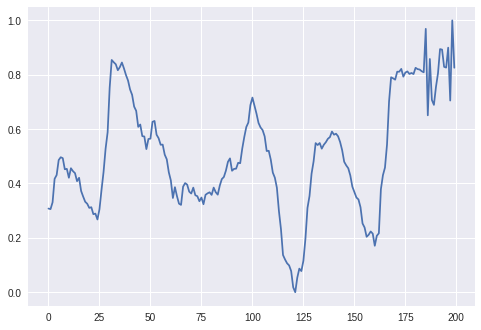

In [61]:
import matplotlib.pyplot as plt
# plt.plot(score1)
plt.plot(score)
# plt.legend(['epoch 47', 'epoch 35'], loc='upper left')
plt.show()


In [0]:
import matplotlib.pyplot as plt
from PIL import Image

for n in range(100,125):
  sq_img = np.squeeze(test_cuboid[n][1], axis = 2)
  sq_img = sq_img*255
  sq_img = sq_img.astype('uint8')

  dec_img = np.squeeze(decode_imgs[n][1], axis = 2)
  dec_img = dec_img*255
  dec_img = dec_img.astype('uint8')

  scipy.misc.imsave('drive/Data/testimage'+str(n)+'.png', sq_img)
  scipy.misc.imsave('drive/Data/dec'+str(n)+'.png', dec_img)


# plt.imshow(sq_img)

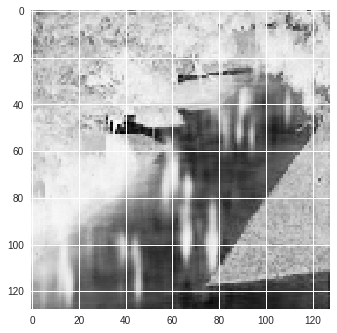

In [0]:
plt.imshow(np.squeeze(decode_imgs[1][1], axis = 2))
  

In [0]:
autoencoder_model.evaluate(test_cuboid, test_cuboid)


193/193 [==============================] - 4s 21ms/step


[0.00776640931385632, 1.1977754108646373e-05, 0.05647316436075794]

In [0]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png',show_shapes=True)

In [0]:
!apt-get install -q graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
